In [34]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Task 1: Analysis of results

### 0. Load data

In [2]:
print('Load data:')
start = time.time()
df = pd.read_parquet("MBD_mini/processed/data.parquet", engine="pyarrow")
print('\t- loaded {} in {:.2f} sec'.format(df.shape, time.time() - start))


Load data:
	- loaded (925679, 2274) in 2.68 sec


### 1. Validate models

In [3]:
def downsample(df, target_column, random_state=42):
    # print('Downsample:')
    
    ### Identify which class is a major/minor class
    class_counts = df[target_column].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    
    df_majority = df[df[target_column] == majority_class]
    df_minority = df[df[target_column] == minority_class]
    # print('\t- df_majority:', df_majority.shape[0])
    # print('\t- df_minority:', df_minority.shape[0])

    ### Target number of samples
    # target_count = int((len(df_majority) + len(df_minority)) / 2) 
    target_count = len(df_minority) * 2

    ### Downsampling of majority_class
    df_majority_down = df_majority.sample(n=target_count, replace=False, random_state=random_state)
    # print('\t- downsampling ready:', df_majority_down.shape[0])
    
    ### Unite
    df_balanced = pd.concat([df_majority_down, df_minority])
    # print('\t- concat done:', df_balanced.shape[0])
    
    ### Shuffle
    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)
    # print('\t- shuffled:', df_balanced.shape[0])
    
    return df_balanced


In [5]:
cols_to_ignore = [
    'client_id', 'mon', 'fold',
    'trans_count', 'diff_trans_date'
]
df['target'] = df[['target_1', 'target_2', 'target_3', 'target_4']].max(1)
features = [col for col in df.columns if col not in cols_to_ignore + ['target', 'target_1', 'target_2', 'target_3', 'target_4']]


In [7]:
N_FOLDS = 5
PATH = 'models/task1'
results = {}

for fold in range(5):
    folder_path = os.path.join(PATH, 'fold={}'.format(fold))
    
    results[fold] = {}
    print('-'*30)
    print(f"Fold {fold}")
    
    ### Get data 
    valid_df = df[df['fold'] == fold]
    print("\t- data was extracted")
    
    ### Upsample / Downsample
    valid_df_sampled = downsample(valid_df, 'target', random_state=42)
    
    ### Dataset
    X_valid = valid_df_sampled[features]
    y_valid = valid_df_sampled['target']

    ### Load model
    model_path = os.path.join(folder_path, f'model.txt')
    model = lgb.Booster(model_file=model_path)

    ### Predict
    preds = model.predict(X_valid, num_iteration=model.best_iteration)
    binary_preds = (preds > 0.5).astype(int)
    print("\t- prediction is finished")
    
    ### Metrics
    results[fold] = {
        'model': model,
        'auc': roc_auc_score(y_valid, preds),
        'accuracy': accuracy_score(y_valid, binary_preds),
        'precision': precision_score(y_valid, binary_preds),
        'recall': recall_score(y_valid, binary_preds),
        'f1': f1_score(y_valid, binary_preds),
        'cm': confusion_matrix(y_valid, binary_preds),
        'y_true': y_valid,       # Сохраняем истинные метки
        'preds': preds  
    }
    print("\t- metrics")
    for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
        val = results[fold][metric]
        print(f"\t\t- {metric}: {val}")
    

------------------------------
Fold 0
	- data was extracted
	- prediction is finished
	- metrics
		- auc: 0.7761427407383196
		- accuracy: 0.7128741644870678
		- precision: 0.5534274193548387
		- recall: 0.7179598953792502
		- f1: 0.6250474383301707
------------------------------
Fold 1
	- data was extracted
	- prediction is finished
	- metrics
		- auc: 0.7728243953412872
		- accuracy: 0.7078078078078078
		- precision: 0.546949965729952
		- recall: 0.7189189189189189
		- f1: 0.6212534059945504
------------------------------
Fold 2
	- data was extracted
	- prediction is finished
	- metrics
		- auc: 0.7766430571819523
		- accuracy: 0.7116306954436451
		- precision: 0.5503018108651911
		- recall: 0.7378597122302158
		- f1: 0.6304264310411064
------------------------------
Fold 3
	- data was extracted
	- prediction is finished
	- metrics
		- auc: 0.7738616625788638
		- accuracy: 0.7065759637188208
		- precision: 0.5461538461538461
		- recall: 0.7083900226757369
		- f1: 0.616781836130306
--

#### 1.1 Mean & std metrics among all folders

In [17]:
metric_names = ['auc', 'accuracy', 'precision', 'recall', 'f1']

metrics = {metric: [] for metric in metric_names}   
for fold in results:
    for metric in metric_names:
        metrics[metric].append(results[fold][metric])

### Calc mean and std
aggregated_results = {}
for metric in metric_names:
    values = np.array(metrics[metric])
    aggregated_results[metric] = {
        'mean': np.mean(values),
        'std': np.std(values)
    }

print('Aggregated result:')
for metric, stats in aggregated_results.items():
    print(f"  {metric}: mean = {stats['mean']:.4f}, std = {stats['std']:.4f}")


Aggregated result:
  auc: mean = 0.7756, std = 0.0021
  accuracy: mean = 0.7105, std = 0.0028
  precision: mean = 0.5504, std = 0.0036
  recall: mean = 0.7178, std = 0.0113
  f1: mean = 0.6230, std = 0.0045


#### 1.2 ROC curve

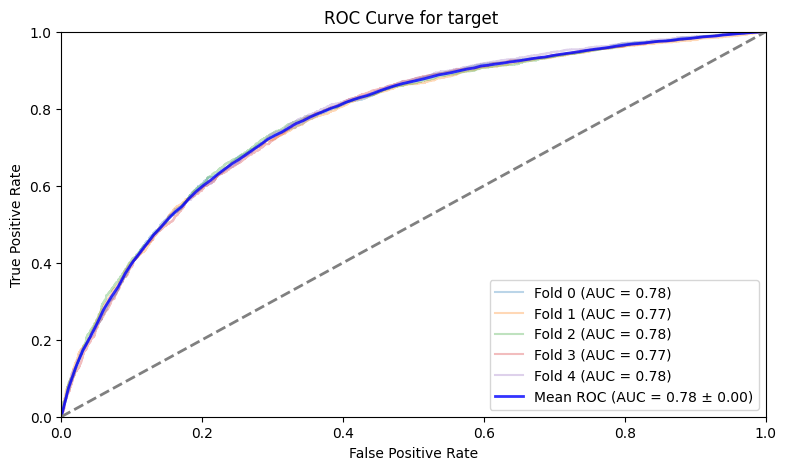

In [20]:
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 2, 1)
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for fold in results:

    y_true = results[fold]['y_true']
    y_score = results[fold]['preds']
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    ax1.plot(fpr, tpr, alpha=0.3, label=f'Fold {fold} (AUC = {roc_auc:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax1.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2, alpha=0.8)
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'ROC Curve for target ')
ax1.legend(loc='lower right')



#### 1.3 Precision-Recall Curve

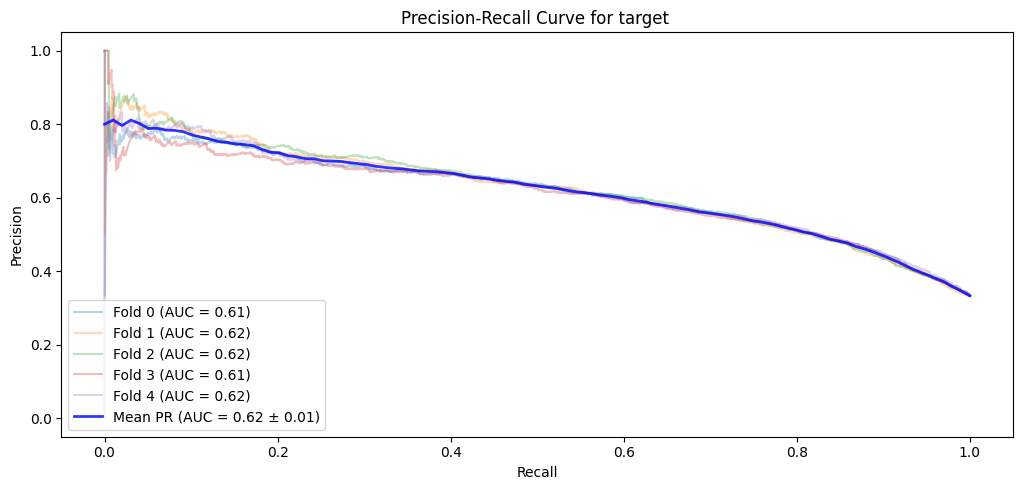

In [21]:
#### Precision-Recall curve 
plt.figure(figsize=(20, 5))

ax2 = plt.subplot(1, 2, 1)
mean_recall = np.linspace(0, 1, 100)
interp_precisions = []
pr_aucs = []

for fold in results:
    y_true = results[fold]['y_true']
    y_score = results[fold]['preds']
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)
    pr_aucs.append(pr_auc)
    
    interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
    interp_precisions.append(interp_precision)
    ax2.plot(recall, precision, alpha=0.3, label=f'Fold {fold} (AUC = {pr_auc:.2f})')

mean_precision = np.mean(interp_precisions, axis=0)
mean_pr_auc = auc(mean_recall, mean_precision)
std_pr_auc = np.std(pr_aucs)
ax2.plot(mean_recall, mean_precision, color='b', label=f'Mean PR (AUC = {mean_pr_auc:.2f} ± {std_pr_auc:.2f})', lw=2, alpha=0.8)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title(f'Precision-Recall Curve for target ')
ax2.legend(loc='lower left')

plt.tight_layout()
plt.show()

#### 1.4 Optimal threshold: F1-score

In [22]:
def find_optimal_threshold(y_true, y_probs, metric=f1_score, thresholds=np.linspace(0, 1, 101)):
    best_thresh = 0.5
    best_score = 0
    scores = []
    
    for thresh in thresholds:
        y_pred = (y_probs > thresh).astype(int)
        score = metric(y_true, y_pred)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_thresh = thresh
    return best_thresh, best_score, scores


In [24]:
### Get optimal thresholds for each model & target
optimal_thresholds = {}  
for fold in results:
    y_true = results[fold]['y_true']
    y_probs = results[fold]['preds']
    opt_thresh, best_f1, _ = find_optimal_threshold(y_true, y_probs, metric=f1_score)

    optimal_thresholds[fold] = {'threshold': opt_thresh, 'f1': best_f1}
    print(f"Fold: {fold} -> Optimal t: {opt_thresh:.2f}, Best F1: {best_f1:.4f}")


Fold: 0 -> Optimal t: 0.48, Best F1: 0.6256
Fold: 1 -> Optimal t: 0.44, Best F1: 0.6232
Fold: 2 -> Optimal t: 0.48, Best F1: 0.6312
Fold: 3 -> Optimal t: 0.43, Best F1: 0.6278
Fold: 4 -> Optimal t: 0.45, Best F1: 0.6314


In [27]:
### Aggregated results 
thresholds = []
f1_scores = []
for fold in optimal_thresholds:
    thresholds.append(optimal_thresholds[fold]['threshold'])
    f1_scores.append(optimal_thresholds[fold]['f1'])
aggregated_thresholds = {
    'mean_threshold': np.mean(thresholds),
    'std_threshold': np.std(thresholds),
    'mean_f1': np.mean(f1_scores),
    'std_f1': np.std(f1_scores)
}

print("Aggregated thresholds:")
print(f"  Mean threshold: {aggregated_thresholds['mean_threshold']:.2f} ± {aggregated_thresholds['std_threshold']:.2f}")
print(f"  Mean F1: {aggregated_thresholds['mean_f1']:.4f} ± {aggregated_thresholds['std_f1']:.4f}")


Aggregated thresholds:
  Mean threshold: 0.46 ± 0.02
  Mean F1: 0.6278 ± 0.0032


#### 1.5 Features importance

In [29]:
### Calculate for all targets & folds
feature_importances = []

for fold in results:
    model = results[fold]['model']

    features_names = model.feature_name()
    importances = model.feature_importance(importance_type='gain')

    df_imp = pd.DataFrame({
        'feature': features_names,
        'importance': importances
    })
    df_imp['fold'] = fold
    df_imp['target'] = target
    
    feature_importances.append(df_imp)



Features importance
                         feature           mean            std
1854       trx_event_type_40_sum  390676.702326  175615.005859
1762    trx_event_subtype_52_sum  264312.053983  218786.859036
1853      trx_event_type_40_mean  233611.076843  241799.077273
235            dialog_avg_emb_31  106555.404287   54667.108275
1961     trx_src_type12_47.0_sum   97397.700085   18421.928167
1761   trx_event_subtype_52_mean   94607.203695   33686.579930
474           dialog_avg_emb_525   72039.182547   75472.571199
1931            trx_recency_days   70557.601975    6185.356425
1564         trx_amount_11.0_sum   56538.551207   14947.240860
55            dialog_avg_emb_148   47720.704189   57915.526477
2213     trx_src_type32_26.0_sum   40793.753831    6468.130188
2221     trx_src_type32_36.0_sum   38878.722095    3844.147325
1985     trx_src_type21_-1.0_sum   36682.685592    7484.956910
780          dialog_recency_days   29592.006380    3295.321020
2053     trx_src_type22_38.0_sum  

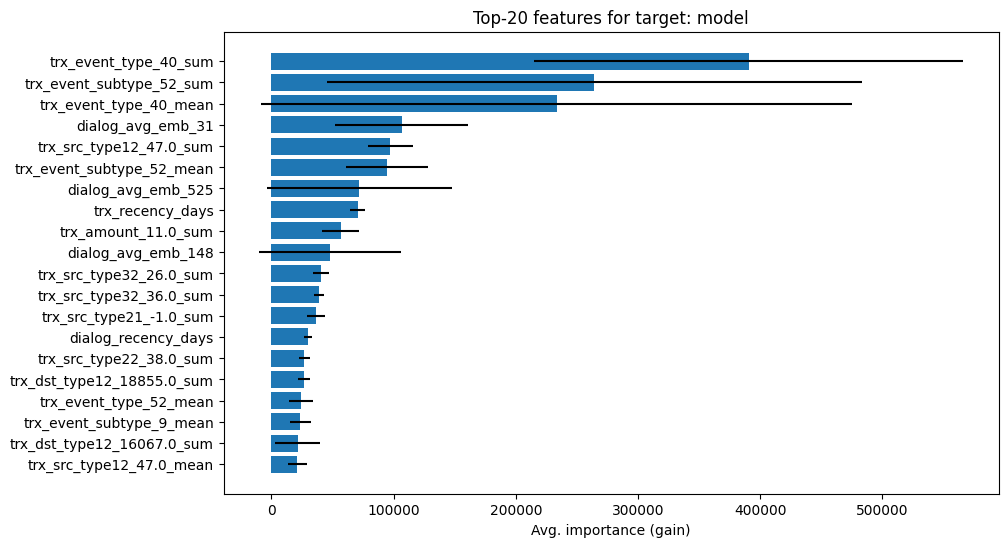

In [32]:
### Aggregate over folds
aggregated_importances = {}

df_all = pd.concat(feature_importances, axis=0)
agg_df = df_all.groupby('feature')['importance'].agg(['mean', 'std']).reset_index()
agg_df = agg_df.sort_values(by='mean', ascending=False)
aggregated_importances[target] = agg_df

print(f"\nFeatures importance")
print(agg_df.head(20))

plt.figure(figsize=(10,6))
plt.barh(agg_df['feature'].head(20)[::-1], agg_df['mean'].head(20)[::-1], xerr=agg_df['std'].head(20)[::-1])
plt.xlabel('Avg. importance (gain)')
plt.title(f'Top-20 features for target: {target}')
plt.show()


#### 1.6 Confusion matrices

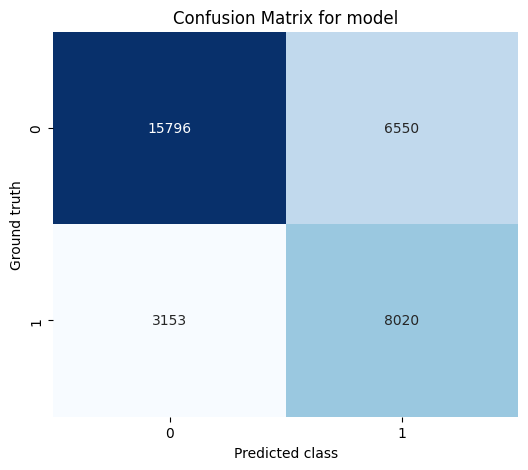

In [35]:
aggregated_cm = []

for fold in results:

    cm = np.array(results[fold]['cm'])
    if len(aggregated_cm) == 0:
        aggregated_cm = cm.copy() 
    else:
        aggregated_cm += cm  


# print(target, cm)
plt.figure(figsize=(6, 5))
sns.heatmap(aggregated_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted class")
plt.ylabel("Ground truth")
plt.title(f"Confusion Matrix for {target}")
plt.show()


### 2. Conclusion
A model for predicting the probability of purchasing at least one product in the next month was built, yielding the following aggregated results:

- AUC: 0.7756 ± 0.0021
- Accuracy: 0.7105 ± 0.0028
- Precision: 0.5504 ± 0.0036
- Recall: 0.7178 ± 0.0113
- F1: 0.6230 ± 0.0045

The optimal threshold was 0.46 (± 0.02), with a mean F1 of 0.6278 (± 0.0032). Although the performance is promising, there is still room for improvement; however, due to time constraints, a general approach was chosen.